In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import rc

In [39]:
threshold = 1

# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

def get_score(y_test, y_pred, **kwargs):
    dataframe = pd.DataFrame(y_test, columns=['y_test'])
    dataframe['predictions'] = y_pred
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [40]:
random_state=20

In [41]:
# Import data and preprocess
df = pd.read_csv("../test_data/new leaky wave/S11_Data_combined.csv")
# df = pd.read_csv("../test_data/Grounded CPW Leaky Wave antenna/S11 Data.csv")
df = df.drop(df[df['dB(S(1,1)) []'] > 0].index) # Remove all rows with positive s11

# # Split into x and y
# input_x = df.drop(columns=['dB(S(1,1)) []'], axis=1)
# input_y = df[['dB(S(1,1)) []']]

# Split data into training and testing
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
X_train = train_df.copy()
X_test = test_df.copy()
y_train = X_train.pop('dB(S(1,1)) []')
y_test = X_test.pop('dB(S(1,1)) []')

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
import keras_tuner
class AntennaModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu', input_shape=self.input_shape))
        model.add(keras.layers.Dense(1)) # Output layer

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=0.1)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mse']
                     )

        return model

In [44]:
import keras_tuner
antenna_model = AntennaModel(input_shape=[len(X_train.keys())])
tuner = keras_tuner.RandomSearch(
    antenna_model,
    objective='val_mse',
    max_trials=3,
    executions_per_trial=1)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2, validation_data = (X_test_scaled, y_test), callbacks=[stop_early])

Trial 3 Complete [00h 00m 31s]
val_mse: 10.991816520690918

Best val_mse So Far: 10.991816520690918
Total elapsed time: 00h 01m 54s


In [45]:
history = tuner.oracle.get_best_trials(num_trials=1)[0]

In [46]:
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [47]:
best_hps.values

{'num_layers': 2,
 'units_0': 96,
 'learning_rate': 0.06314851574005205,
 'units_1': 480,
 'units_2': 448,
 'units_3': 448}

In [48]:
print('units_1:', best_hps.get('units_1'))
print('learning rate:', best_hps.get('learning_rate'))
print('best model name:', best_model.metrics_names)
print('mse:', best_model.evaluate(X_test_scaled, y_test))

units_1: 480
learning rate: 0.06314851574005205
best model name: []
167/167 [==============================] - 0s 895us/step - loss: 10.9918 - mse: 10.9918
mse: [10.991816520690918, 10.991816520690918]


In [49]:
best_model.save("dnn_lwn.h5")

/opt/miniconda3/envs/tylers_env_do_not_touch/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# best_model = tf.keras.models.load_model("dnn.h5")

In [51]:
%%time
test_predictions = best_model.predict(X_test_scaled)

167/167 [==============================] - 0s 665us/step
CPU times: user 274 ms, sys: 9.56 ms, total: 284 ms
Wall time: 228 ms


In [52]:
%%time
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)
dnn_model = tuner.hypermodel.build(best_hps)
history_tuned= dnn_model.fit(X_train_scaled, y_train, 
          epochs = 500, 
          validation_data = (X_test_scaled, y_test),
          verbose=1,
          callbacks= early_stopping_cb)

Epoch 1/500
667/667 [==============================] - 2s 2ms/step - loss: 23.4760 - mse: 23.4760 - val_loss: 14.5056 - val_mse: 14.5056
Epoch 2/500
667/667 [==============================] - 2s 3ms/step - loss: 15.6389 - mse: 15.6389 - val_loss: 13.7559 - val_mse: 13.7559
Epoch 3/500
667/667 [==============================] - 3s 4ms/step - loss: 14.9040 - mse: 14.9040 - val_loss: 13.4310 - val_mse: 13.4310
Epoch 4/500
667/667 [==============================] - 3s 4ms/step - loss: 14.6874 - mse: 14.6874 - val_loss: 12.8047 - val_mse: 12.8047
Epoch 5/500
667/667 [==============================] - 3s 5ms/step - loss: 14.1855 - mse: 14.1855 - val_loss: 12.2884 - val_mse: 12.2884
Epoch 6/500
667/667 [==============================] - 3s 5ms/step - loss: 13.9208 - mse: 13.9208 - val_loss: 12.1935 - val_mse: 12.1935
Epoch 7/500
667/667 [==============================] - 3s 5ms/step - loss: 13.8345 - mse: 13.8345 - val_loss: 13.6493 - val_mse: 13.6493
Epoch 8/500
667/667 [====================

In [53]:
import pickle
with open("dnn_lwn.pkl", "wb") as file:
    pickle.dump(history_tuned, file)

# with open("dnn.pkl", "rb") as file:
#     history_tuned = pickle.load(file)

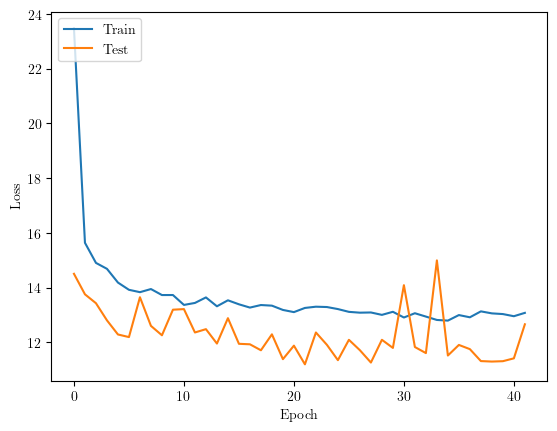

In [54]:
# Make the font the same as latex 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
best_model.evaluate(X_test_scaled, y_test, verbose=0)

[10.991816520690918, 10.991816520690918]

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

model = RandomForestRegressor(max_depth=35, min_samples_leaf=1, min_samples_split=2, n_estimators=325, random_state=random_state)
scaler = StandardScaler() # Initialize scaler
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)]) # Create pipeline with scaler and model


In [67]:
%%time
pipeline_fit = pipeline.fit(X_train, y_train)

CPU times: user 14.3 s, sys: 227 ms, total: 14.6 s
Wall time: 15.6 s


In [68]:
%%time
sklearn_predictions = pipeline_fit.predict(X_test)

CPU times: user 405 ms, sys: 0 ns, total: 405 ms
Wall time: 520 ms


In [69]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test.values.ravel(), sklearn_predictions, squared=False)

2.2323619689351526

In [70]:
print(f"tensorflow score: {get_score(y_test.values.ravel(), test_predictions)}")
print(f"sklearn score: {get_score(y_test.values.ravel(), sklearn_predictions)}")

tensorflow score: 0.333208325520345
sklearn score: 0.66641665104069


In [71]:
scatter_plot_df = pd.DataFrame({
    's11_true': y_test.values.tolist() * 2,
    's11_prediction': np.concatenate((sklearn_predictions,test_predictions.reshape(-1))),
    's11_source': (['Sklearn'] * len(y_test.values.tolist())) + (['TensorFlow'] * len(y_test.values.tolist())),
    's11_color': (['red'] * len(y_test.values.tolist())) + (['blue'] * len(y_test.values.tolist()))
})

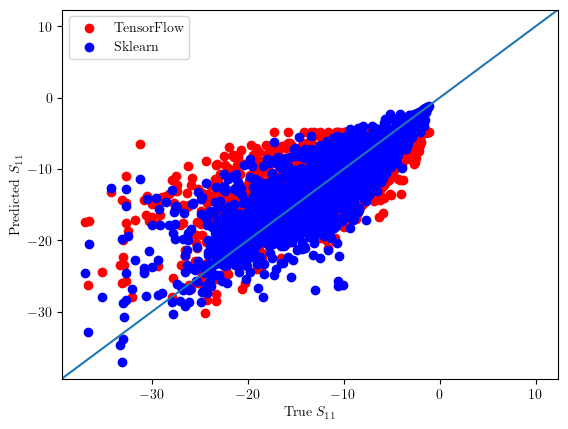

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, test_predictions, label="TensorFlow", c='r')
ax1.scatter(y_test, sklearn_predictions, label="Sklearn", c='b')
plt.xlabel('True $S_{11}$')
plt.ylabel('Predicted $S_{11}$')
plt.axline((-30,-30), (10,10))
plt.legend(loc='upper left')
plt.show()

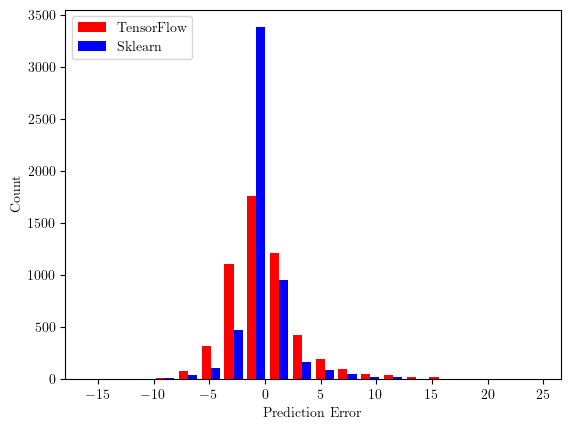

In [73]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
error_tensorflow = test_predictions.reshape(-1) - y_test
error_sklearn = sklearn_predictions - y_test
ax1.hist([error_tensorflow, error_sklearn], bins=20, color=['red', 'blue'], label=['TensorFlow', 'Sklearn'])
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

In [74]:
analysis_df = X_test.copy()
analysis_df['dB(S(1,1)) []'] = y_test
analysis_df['tensorflow predicted s11'] = test_predictions.reshape(-1)
analysis_df['sklearn predicted s11'] = sklearn_predictions

In [75]:
analysis_df

,cpw_in [mm],feed_l [mm],patch_l [mm],cpw_g [mm],Feed_W [mm],ground_w [mm],patch_ground_w [mm],patch_w [mm],Freq [GHz],"dB(S(1,1)) []",tensorflow predicted s11,sklearn predicted s11
10,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.90,-3.687785,-4.841832,-3.814358
13,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,12.17,-4.757401,-4.841832,-5.130616
19,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,12.71,-6.767213,-4.841832,-7.675155
28,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,13.52,-7.216387,-9.289400,-7.453351
40,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,14.60,-7.811985,-9.735253,-11.272109
...,...,...,...,...,...,...,...,...,...,...,...,...
26638,2.0,3.75,3.50,0.18,1.0,1.5,1.5,5.00,17.75,-7.610843,-11.082159,-7.594560
26641,2.0,3.75,3.50,0.18,1.0,1.5,1.5,5.00,18.02,-13.640745,-9.689838,-13.792042
26648,2.0,3.75,3.50,0.18,1.0,1.5,1.5,5.00,18.65,-4.601866,-7.118733,-4.577615
26655,2.0,3.75,3.50,0.18,1.0,1.5,1.5,5.00,19.28,-4.938332,-5.183437,-5.407977
